In [ ]:
# установка библиотек для eda согласно файлу requirements.txt
# %pip install torch==2.8.0 torchvision==0.23.0 opencv-python==4.12.0.88 pillow==11.3.0

In [ ]:
# импорт библиотек и конфигурация
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision
import torchvision.transforms.v2 as tfs
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
import os
from torch.utils.data import DataLoader, random_split
import torch.utils.data as data
from tqdm import tqdm

# подключение к cuda, если есть
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"OpenCV version: {cv2.__version__}")
print(f"Pillow version: {PIL.__version__}")

Torch version: 2.8.0+cu126
Torchvision version: 0.23.0+cu126
OpenCV version: 4.12.0
Pillow version: 11.3.0


In [ ]:
# !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz


--2025-10-07 10:41:51--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.3’

cifar-10-python.tar 100%[===================>] 162.60M  63.6MB/s    in 2.6s    

2025-10-07 10:41:53 (63.6 MB/s) - ‘cifar-10-python.tar.gz.3’ saved [170498071/170498071]



In [ ]:
# !tar -xvzf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


# Улучшенные модели

In [ ]:
mean_cifar = (0.4914, 0.4822, 0.4465)
std_cifar = (0.2470, 0.2435, 0.2616)

# трансформации для тренировочной и валидационной выборки
transform_train = tfs.Compose([
    tfs.ToImage(),                             # (опционально) PIL->Image
    tfs.ToDtype(torch.uint8, scale=True),      # явный uint8, scale=True - нормировка [0, 1]
    # геометрические аугментации
    tfs.RandomHorizontalFlip(),                # горизонтальное отражение
    tfs.RandomCrop(32, padding=4),             # случаный кроп
    # к float (в [0,1]) перед нормализацией
    tfs.ToDtype(torch.float32, scale=True),
    tfs.Normalize(mean_cifar, std_cifar)       # (x-mean)/std -> mean/std = (0, 1)
])

# трансформации для тестовой выборки
transform_test = tfs.Compose([
    tfs.ToImage(),
    tfs.ToDtype(torch.uint8, scale=True),
    # tfs.Resize((32,32), antialias=True),       #изменение размера если нужно
    tfs.ToDtype(torch.float32, scale=True),
    tfs.Normalize(mean_cifar, std_cifar)
])


In [ ]:
# загрузка датасета CIFAR-10 из torchvision.datasets

# размер батча
batch_size = 128

# загрузка train и деление на train/val - 8/2
trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# print(len(trainset_full))

# train_size = 45000
# val_size = len(trainset_full) - train_size
# trainset, valset = data.random_split(trainset_full, [train_size, val_size])

trainset, valset = data.random_split(trainset_full, [0.8, 0.2])
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

# загрузка test
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# метки
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
# CNN
# - conv→BN→ReLU→pool блоки ×3 — извлечение признаков
# - Dropout в полносвязной части — борьба с переобучением
# - Scheduler — снижение lr по эпохам

class BetterCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
cnn = BetterCNN().to(device)
criterion = nn.CrossEntropyLoss()
                                                        # L2 регуляризация
optimizer_cnn = optim.Adam(cnn.parameters(), lr=0.001, weight_decay=1e-4)
scheduler_cnn = StepLR(optimizer_cnn, step_size=10, gamma=0.5)

[CNN] Epoch 1/25 | Train Loss: 1.6374 | Val Loss: 1.3534 | Val F1(macro): 0.4905
[CNN] Epoch 2/25 | Train Loss: 1.3263 | Val Loss: 1.2441 | Val F1(macro): 0.5367
[CNN] Epoch 3/25 | Train Loss: 1.2035 | Val Loss: 1.1096 | Val F1(macro): 0.5920
[CNN] Epoch 4/25 | Train Loss: 1.1252 | Val Loss: 1.0112 | Val F1(macro): 0.6300
[CNN] Epoch 5/25 | Train Loss: 1.0557 | Val Loss: 0.9166 | Val F1(macro): 0.6704
[CNN] Epoch 6/25 | Train Loss: 1.0122 | Val Loss: 1.0182 | Val F1(macro): 0.6311
[CNN] Epoch 7/25 | Train Loss: 0.9797 | Val Loss: 0.8742 | Val F1(macro): 0.6869
[CNN] Epoch 8/25 | Train Loss: 0.9348 | Val Loss: 0.8712 | Val F1(macro): 0.6855
[CNN] Epoch 9/25 | Train Loss: 0.9206 | Val Loss: 0.7840 | Val F1(macro): 0.7120
[CNN] Epoch 10/25 | Train Loss: 0.8892 | Val Loss: 0.8060 | Val F1(macro): 0.7143
[CNN] Epoch 11/25 | Train Loss: 0.8075 | Val Loss: 0.7331 | Val F1(macro): 0.7331
[CNN] Epoch 12/25 | Train Loss: 0.7901 | Val Loss: 0.7005 | Val F1(macro): 0.7525
[CNN] Epoch 13/25 | Train

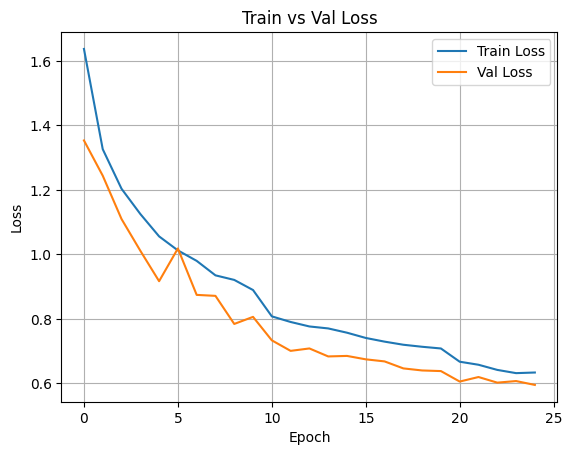

In [ ]:
# Обучение и валидация
# списки потерь
train_losses = []
val_losses = []

num_epochs = 25  # 30
for epoch in range(num_epochs):
    # обучение
    cnn.train()   # режим обучения (Dropout, BatchNorm - on)
    running_loss = 0.0    # накопитель суммы loss'ов по батчам

    for images, labels in trainloader:
        # перенос данных на device (GPU/CPU)
        images, labels = images.to(device), labels.to(device)

        # forward
        outputs = cnn(images)
        loss = criterion(outputs, labels)

        # backward + step
        optimizer_cnn.zero_grad()
        loss.backward()
        optimizer_cnn.step()

        # увеличиваем loss, loss.item() - средний по этому батчу
        running_loss += loss.item()

    # средний loss по эпохе (по батчам)
    train_loss_mean = running_loss / len(trainloader) if len(trainloader) > 0 else 0.0
    train_losses.append(train_loss_mean)

    # валидация
    cnn.eval()    # режим инференса (Dropout - off, BN использует накопленные статистики)

    val_loss_sum = 0.0    # сумма loss'ов по батчам при валидации
    val_batches = 0   # число батчей на валидации

    all_preds, all_labels = [], []    # списки предсказаний и реальных меток

    # отключить градиенты
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)

            predict = cnn(images)
            loss = criterion(predict, labels)

            # увеличить накопленный валидационный loss
            val_loss_sum += loss.item()
            val_batches += 1

            # предсказанные классы
            _, predicted = torch.max(predict, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # защита на случай пустого valloader
    val_loss_mean = val_loss_sum / val_batches if val_batches > 0 else 0.0
    val_losses.append(val_loss_mean)

    # метрики
    val_f1_macro = f1_score(all_labels, all_preds, average='macro')
    val_acc = accuracy_score(all_labels, all_preds)

    # результаты по эпохе
    print(f"[CNN] Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss_mean:.4f} | "
          f"Val Loss: {val_loss_mean:.4f} | Val F1(macro): {val_f1_macro:.4f}")

    # изменить lr
    scheduler_cnn.step()

# графики
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Val Loss')
plt.legend()
plt.grid()
plt.show()

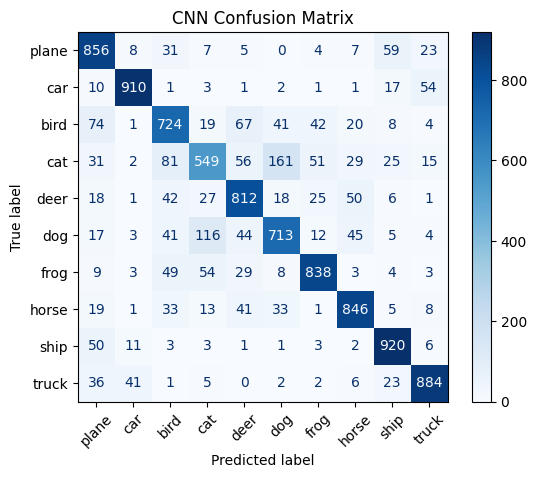


[CNN] Final Test Accuracy: 0.8052
[CNN] Final Test F1 (macro): 0.8030


TypeError: only length-1 arrays can be converted to Python scalars

In [ ]:
# тестирование, метрики и матрица ошибок
cnn.eval()

y_true, y_pred = [], [] # реальные и предсказанные классы
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn(images)
        _, predicted = torch.max(outputs, 1) # предсказанный класс
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# расчет метрик и матрицы ошибок
test_acc = accuracy_score(y_true, y_pred)
test_f1_macro = f1_score(y_true, y_pred, average='macro')
test_f1_per_class = f1_score(y_true, y_pred, average=None)

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot(xticks_rotation=45, cmap='Blues')
plt.title("CNN Confusion Matrix")
plt.show()

print(f"\n[CNN] Final Test Accuracy: {test_acc:.4f}")
print(f"[CNN] Final Test F1 (macro): {test_f1_macro:.4f}")
# print(f"[CNN] Final Test F1 (per class): {dict(zip(classes, float(test_f1_per_class)))}")
print(f"[CNN] Final Test F1 (per class): {test_f1_per_class}")

In [ ]:
# ResNet18
# используем предобученные веса ImageNet
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# адаптация первых слоев под 32×32
resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
# вместо maxpool - "прозрачный" слой
resnet.maxpool = nn.Identity()

# "замораживаем" все слои, размораживаем начиная с layer2
for param in resnet.parameters():
    param.requires_grad = False
for layer in [resnet.layer2, resnet.layer3, resnet.layer4]:
    for param in layer.parameters():
        param.requires_grad = True

# последний линейный слой - классификатор под CIFAR-10
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)

resnet = resnet.to(device)

# оптимизатор и scheduler
criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(
    filter(lambda p: p.requires_grad, resnet.parameters()),
    lr=5e-4, weight_decay=1e-4
)
scheduler_resnet = StepLR(optimizer_resnet, step_size=15, gamma=0.5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 203MB/s]


[ResNET] Epoch 1/15 | Train Loss: 0.0956 | Val Loss: 0.3764 | Val F1(macro): 0.8844
[ResNET] Epoch 2/15 | Train Loss: 0.0637 | Val Loss: 0.4498 | Val F1(macro): 0.8749
[ResNET] Epoch 3/15 | Train Loss: 0.0552 | Val Loss: 0.4576 | Val F1(macro): 0.8820
[ResNET] Epoch 4/15 | Train Loss: 0.0502 | Val Loss: 0.4350 | Val F1(macro): 0.8895
[ResNET] Epoch 5/15 | Train Loss: 0.0381 | Val Loss: 0.4245 | Val F1(macro): 0.8899
[ResNET] Epoch 6/15 | Train Loss: 0.0332 | Val Loss: 0.4854 | Val F1(macro): 0.8825
[ResNET] Epoch 7/15 | Train Loss: 0.0343 | Val Loss: 0.5190 | Val F1(macro): 0.8736
[ResNET] Epoch 8/15 | Train Loss: 0.0331 | Val Loss: 0.5151 | Val F1(macro): 0.8827
[ResNET] Epoch 9/15 | Train Loss: 0.0273 | Val Loss: 0.4742 | Val F1(macro): 0.8868
[ResNET] Epoch 10/15 | Train Loss: 0.0247 | Val Loss: 0.4600 | Val F1(macro): 0.8913
[ResNET] Epoch 11/15 | Train Loss: 0.0317 | Val Loss: 0.4818 | Val F1(macro): 0.8815
[ResNET] Epoch 12/15 | Train Loss: 0.0315 | Val Loss: 0.4344 | Val F1(macr

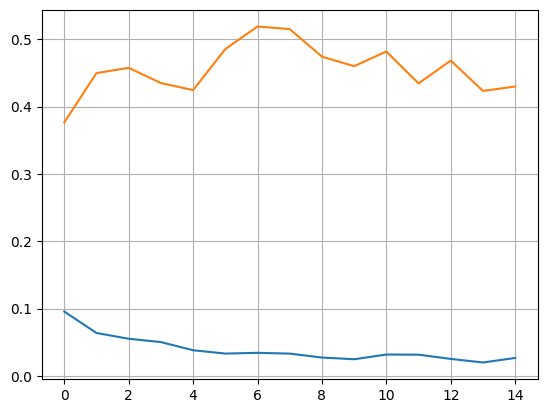

In [ ]:
# для графиков изменения loss на тренировочной и валидационной выборках
train_losses = []
val_losses = []

# Обучение
num_epochs = 15 #30
for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer_resnet.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_resnet.step()
        running_loss += loss.item()

    train_loss_mean = running_loss / len(trainloader)  # средний лосс по эпохе
    train_losses.append(train_loss_mean)

    scheduler_resnet.step()

    resnet.eval()
    val_loss_mean = 0.0
    val_batches = 0

    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)

            loss = criterion(outputs, labels)  # добавляем подсчёт лосса

            val_loss_mean += loss.item()       # суммируем лосс
            val_batches += 1                    # считаем число батчей

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss_mean /= val_batches
    val_losses.append(val_loss_mean)

    val_acc = accuracy_score(all_labels, all_preds)
    val_f1_macro = f1_score(all_labels, all_preds, average='macro')

    print(f"[ResNET] Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss_mean:.4f} | "
          f"Val Loss: {val_loss_mean:.4f} | Val F1(macro): {val_f1_macro:.4f}")


# вывод графиков
plt.plot(train_losses)
plt.plot(val_losses)
plt.grid()
plt.show()

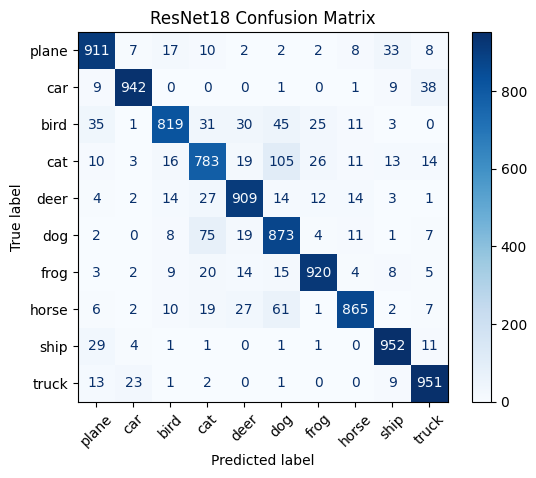


[CNN] Final Test Accuracy: 0.8925
[CNN] Final Test F1 (macro): 0.8925
[CNN] Final Test F1 (per class): [0.90108803 0.94864048 0.86437995 0.79573171 0.9        0.82436261
 0.92415871 0.8987013  0.93654697 0.93143976]


In [ ]:
# Матрица ошибок
y_true, y_pred = [], []
resnet.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot(xticks_rotation=45, cmap='Blues')
plt.title("ResNet18 Confusion Matrix")
plt.show()

test_acc = accuracy_score(y_true, y_pred)
test_f1_macro = f1_score(y_true, y_pred, average='macro')
test_f1_per_class = f1_score(y_true, y_pred, average=None)

print(f"\n[CNN] Final Test Accuracy: {test_acc:.4f}")
print(f"[CNN] Final Test F1 (macro): {test_f1_macro:.4f}")
print(f"[CNN] Final Test F1 (per class): {test_f1_per_class}")

In [ ]:
# сохранение моделей
os.makedirs('models', exist_ok=True)

# CNN
torch.save(cnn.state_dict(), 'models/cnn.pth')
print("CNN модель успешно сохранена в models/cnn.pth")

# ResNet18
torch.save(resnet.state_dict(), 'models/resnet18.pth')
print("ResNet18 модель успешно сохранена в models/resnet18.pth")

CNN модель успешно сохранена в models/cnn.pth
ResNet18 модель успешно сохранена в models/resnet18.pth


In [ ]:
# скачать обученные веса на устройство
from google.colab import files

# CNN
files.download('models/cnn.pth')

# ResNet18
files.download('models/resnet18.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# скачать обученные веса на гугл диск
from google.colab import drive
drive.mount('/content/drive')

# сохранить в Google Drive
!cp models/cnn.pth /content/drive/MyDrive/тестовое
!cp models/resnet18.pth /content/drive/MyDrive/тестовое

Mounted at /content/drive
